# This test is to be able to replicate and compare the outcomes of the original test T-002A Explainer Approximation, to confirm replicability and system performance across different computing hardware and python versions.

Here we check the approximation of samples to the full data in the shap Explainer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\kregh\AppData\Local\Temp\ipykernel_31560\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
data = data.sample(n=10000)

In [9]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6962
1    1038
Name: count, dtype: int64
Test label
0    1752
1     248
Name: count, dtype: int64


In [10]:
train_sample = X_train.sample(n=1000)
train_sample_tensor = torch.tensor(train_sample.values, dtype=torch.float32)
test_sample = X_test.sample(n=1000)
test_sample_tensor = torch.tensor(test_sample.values, dtype=torch.float32)

In [11]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 67.46batch/s]


Epoch [1/5], Train Loss: 0.0820, Train Acc: 0.9685, Train F1: 0.9599


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 84.29batch/s]


Epoch [2/5], Train Loss: 0.0174, Train Acc: 0.9923, Train F1: 0.9922


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 82.93batch/s]


Epoch [3/5], Train Loss: 0.0160, Train Acc: 0.9930, Train F1: 0.9930


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 80.85batch/s]


Epoch [4/5], Train Loss: 0.0137, Train Acc: 0.9935, Train F1: 0.9935


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 81.59batch/s]


Epoch [5/5], Train Loss: 0.0144, Train Acc: 0.9933, Train F1: 0.9932


Testing: 100%|██████████| 16/16 [00:00<00:00, 219.76batch/s]


Test Loss: 0.0184, Test Accuracy: 0.9914, Test F1: 0.9912


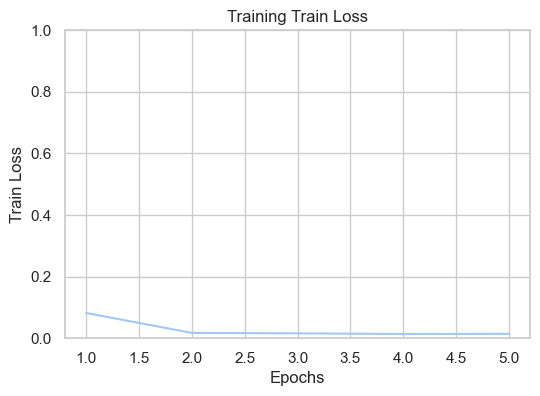

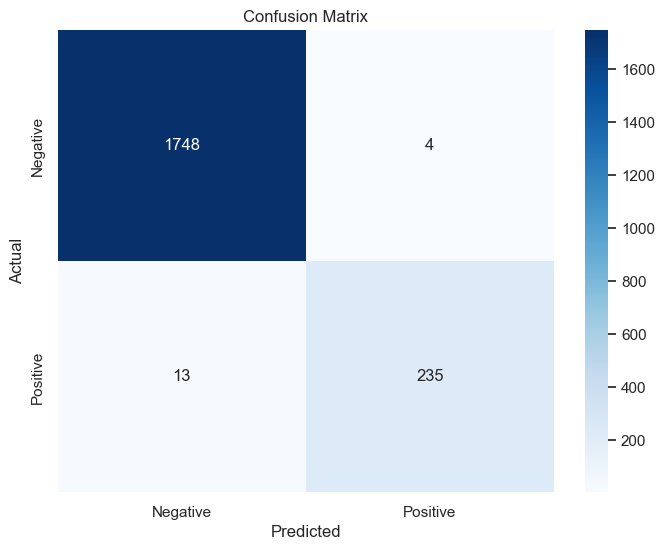

In [13]:
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.01
epochs = 5
save_factor = 100
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

# Difference in test and train background for sampling methods.
Deep Explainer gives us more precise shapely values

# Check Sample
Note: The true sampled training set happens in the training run and a real background can be made by modifying the Dynamic Neural Network model to give it the option to store the dataset.

In [ ]:
# SC - Run time 2m 48.1s

X_test_tensor = X_test_tensor.to('cuda')  # Had to Move test data to GPU

xp1 = shap.DeepExplainer(model1, X_test_tensor)
shap1 = xp1.shap_values(X_test_tensor)

In [ ]:
# SC - Run time 1m 25.1s

test_sample_tensor = test_sample_tensor.to('cuda')  # Had to Move test data to GPU

xp2 = shap.DeepExplainer(model1, test_sample_tensor)
shap2 = xp2.shap_values(X_test_tensor)

# Check standard model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 165.47batch/s]


Epoch [1/5], Train Loss: 0.0884, Train Acc: 0.9656, Train F1: 0.9565


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 172.44batch/s]


Epoch [2/5], Train Loss: 0.0198, Train Acc: 0.9901, Train F1: 0.9901


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 184.80batch/s]


Epoch [3/5], Train Loss: 0.0194, Train Acc: 0.9901, Train F1: 0.9901


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 182.17batch/s]


Epoch [4/5], Train Loss: 0.0167, Train Acc: 0.9922, Train F1: 0.9921


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 169.81batch/s]


Epoch [5/5], Train Loss: 0.0177, Train Acc: 0.9914, Train F1: 0.9914


Testing: 100%|██████████| 16/16 [00:00<00:00, 213.81batch/s]


Test Loss: 0.0188, Test Accuracy: 0.9929, Test F1: 0.9928


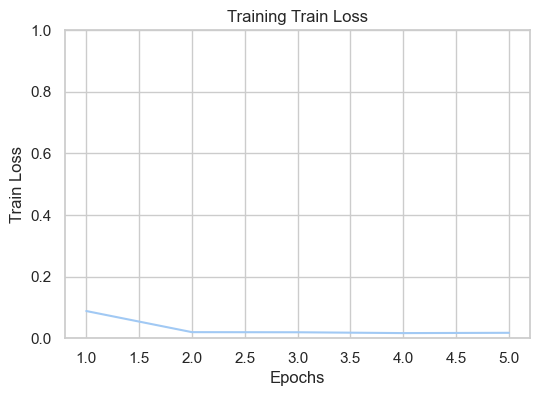

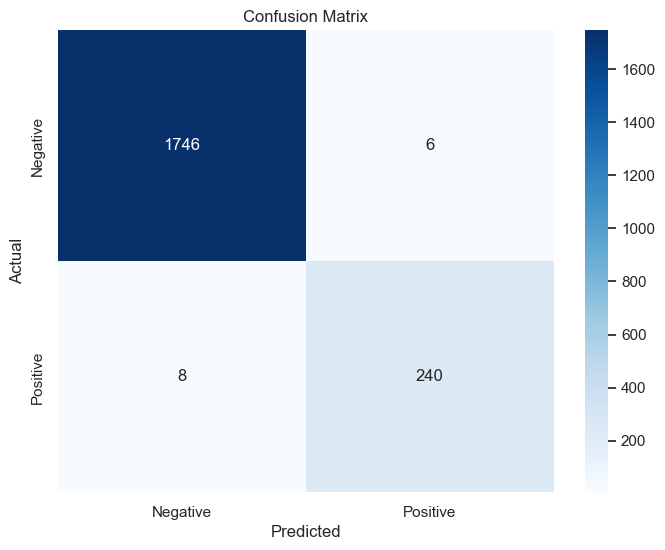

In [17]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
save_factor = 100
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)
model2.test(test_loader)
plot_metrics(model2.train_loss, len(model2.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
# SC - Run time 2m 52.7s

xp3 = shap.DeepExplainer(model2, X_test_tensor)
shap3 = xp3.shap_values(X_test_tensor)

In [ ]:
# SC - Run time 12m 1.0s

X_train_tensor = X_train_tensor.to('cuda')  # Had to Move test data to GPU

xp4 = shap.DeepExplainer(model2, X_train_tensor)
shap4 = xp4.shap_values(X_test_tensor)

In [ ]:
# SC - Run time 1m 29.0s

train_sample_tensor = train_sample_tensor.to('cuda')  # Had to Move test data to GPU

xp5 = shap.DeepExplainer(model2, train_sample_tensor)
shap5 = xp5.shap_values(X_test_tensor)

In [ ]:
# SC - Run time 1m 28.8s

test_sample_tensor = test_sample_tensor.to('cuda')  # Had to Move test data to GPU

xp6 = shap.DeepExplainer(model2, test_sample_tensor)
shap6 = xp6.shap_values(X_test_tensor)

# Random Forest does not hold additivity property due to averaging the baseline. Shifted to XGBoost model.

In [22]:
rf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.991


In [23]:
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.991


In [ ]:
# SC - Run time 1.7s

xp_rf1 = shap.TreeExplainer(rf1, X_test)
shap_rf1 = xp_rf1.shap_values(X_test, check_additivity=False)

In [ ]:
# SC - Run time 2.7s

xp_xgb1 = shap.TreeExplainer(xgb, X_test)
shap_xgb1 = xp_xgb1.shap_values(X_test)

In [ ]:
# SC - Run time 2.6s

xp_xgb2 = shap.TreeExplainer(xgb, X_train)
shap_xgb2 = xp_xgb2.shap_values(X_test)

In [ ]:
# SC - Run time 2.7s

xp_xgb3 = shap.TreeExplainer(xgb, train_sample)
shap_xgb3 = xp_xgb3.shap_values(X_test)

In [ ]:
# SC - Run time 2.6s

xp_xgb4 = shap.TreeExplainer(xgb, test_sample)
shap_xgb4 = xp_xgb4.shap_values(X_test)

# Evaluation

Select non-sparse data

In [29]:
cols = [225, 40, 16, 11, 211, 224, 271, 31, 32, 13]

In [30]:
names = X_train[X_train.columns[[225, 40, 16, 11, 211, 224, 271, 31, 32, 13]]].columns
print(names)

Index(['state_CON', 'proto_tcp', 'dmeansz', 'swin', 'service_none',
       'state_FIN', 'sport_1043', 'ct_srv_src', 'ct_srv_dst', 'stcpb'],
      dtype='object')


Neural Network

Sampled

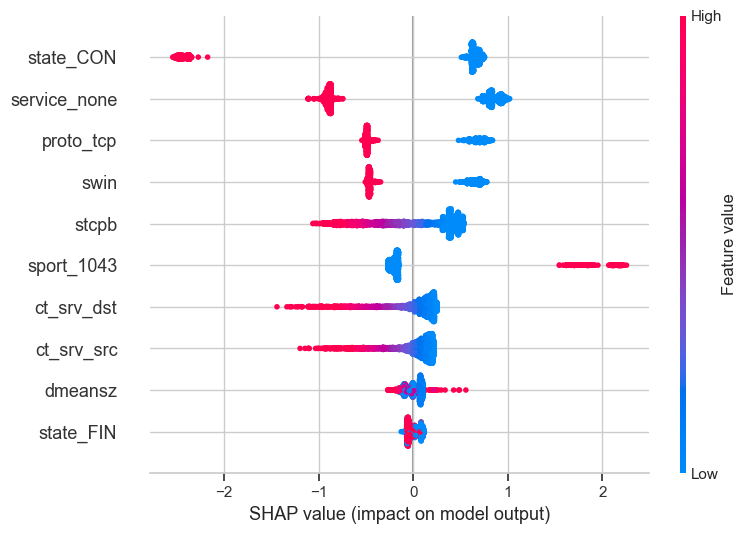

In [31]:
# - SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap1.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

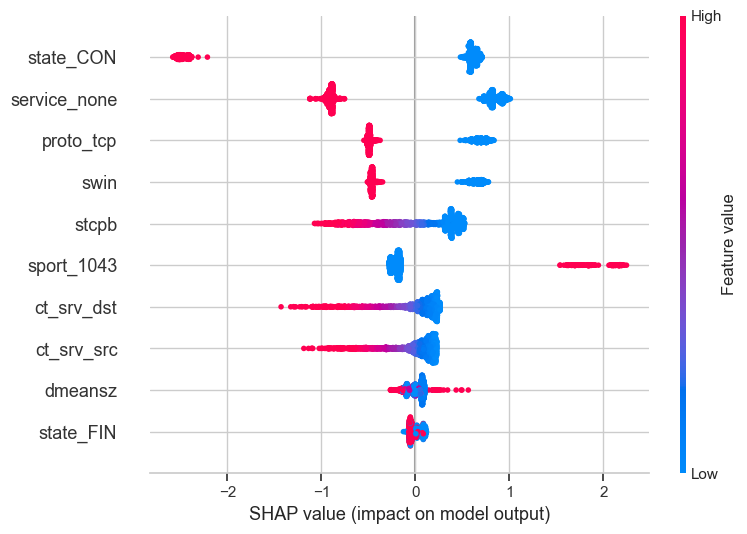

In [32]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap2.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

Standard

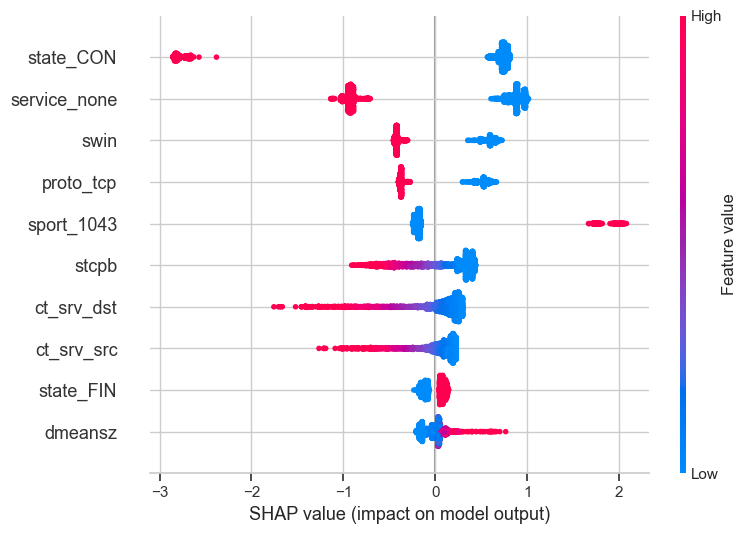

In [33]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap3.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

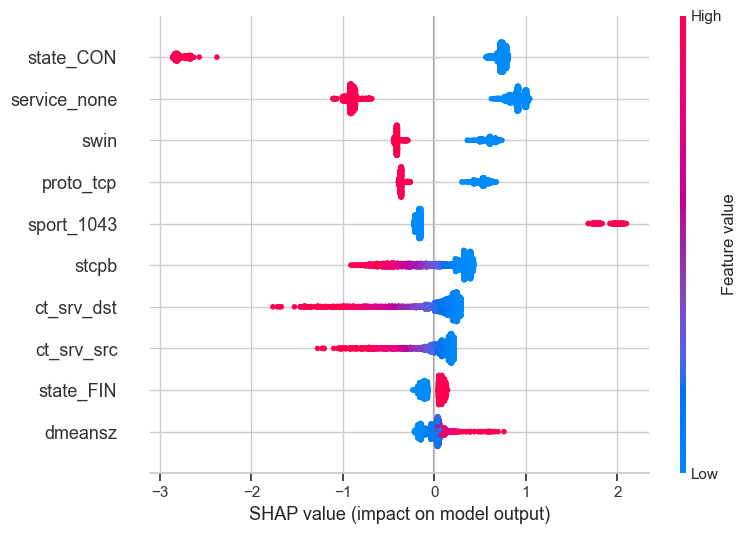

In [34]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap4.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

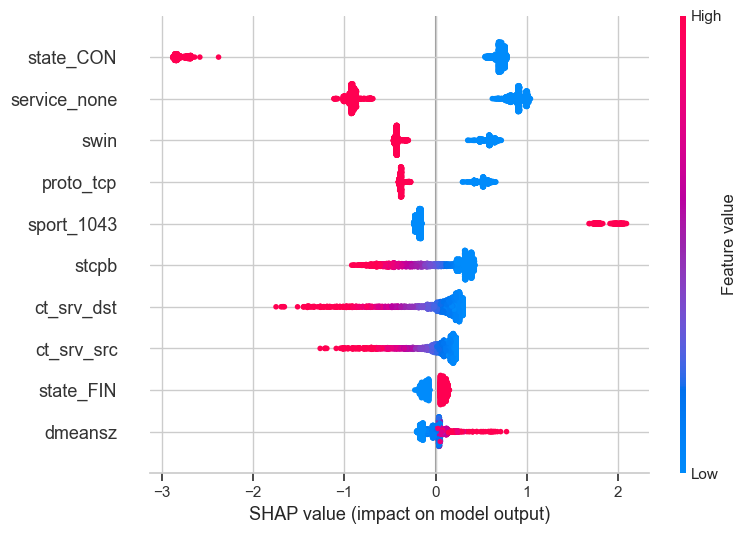

In [35]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap5.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

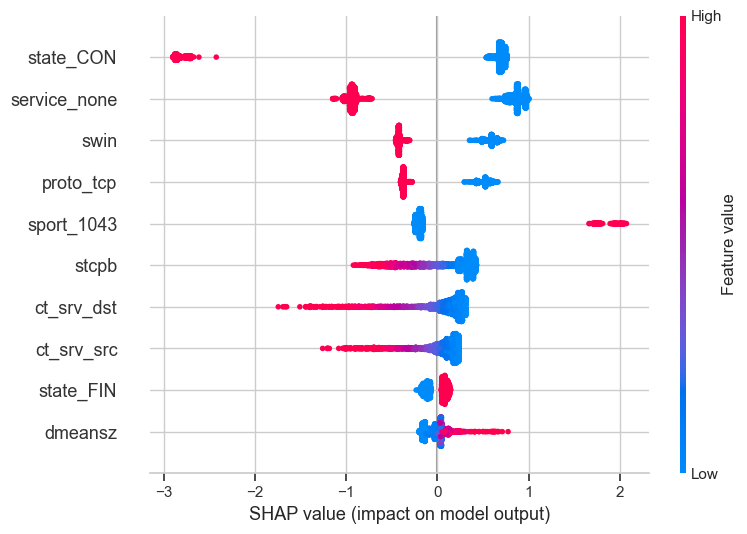

In [36]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap6.squeeze()[:, cols], X_test_tensor[:, cols].detach().cpu().numpy(), feature_names=names)

Random Forest

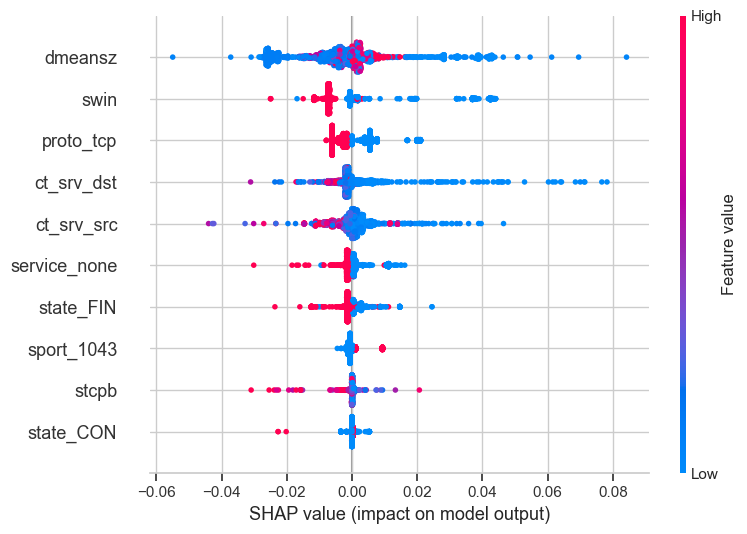

In [37]:
shap.summary_plot(shap_rf1[:, :, 1][:, cols], X_test.iloc[:, cols])

XGBoost

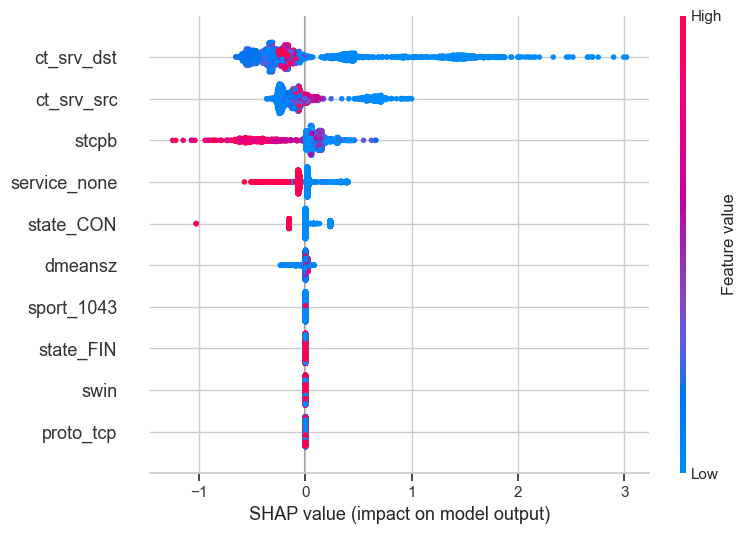

In [38]:
# Interestingly we get a probability output same as a Sigmoid meaning it is valid as a teacher model.
shap.summary_plot(shap_xgb1[:, :][:, cols], X_test.iloc[:, cols])

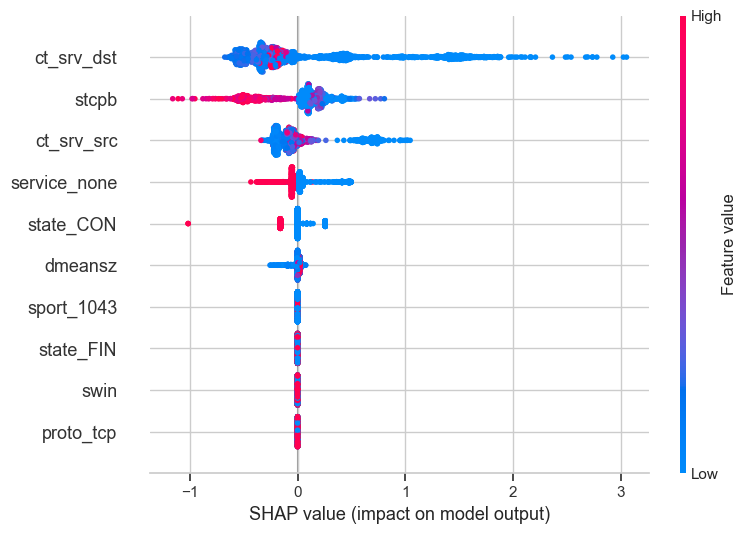

In [39]:
shap.summary_plot(shap_xgb2[:, :][:, cols], X_test.iloc[:, cols])

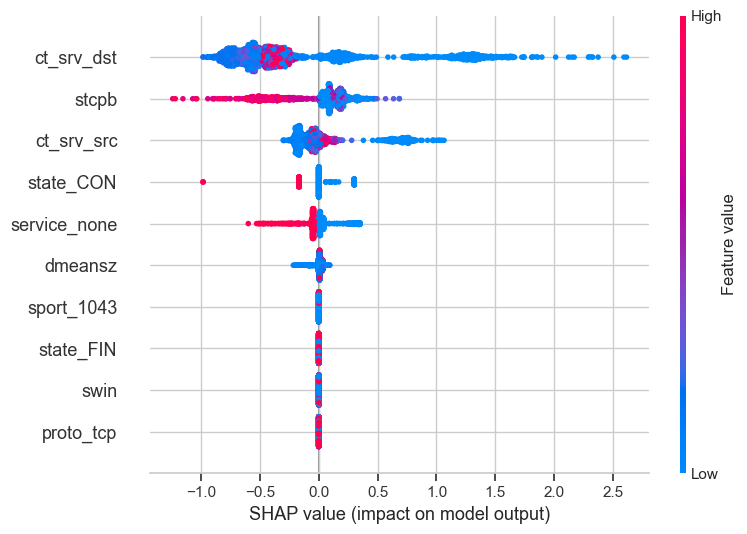

In [40]:
shap.summary_plot(shap_xgb3[:, :][:, cols], X_test.iloc[:, cols])

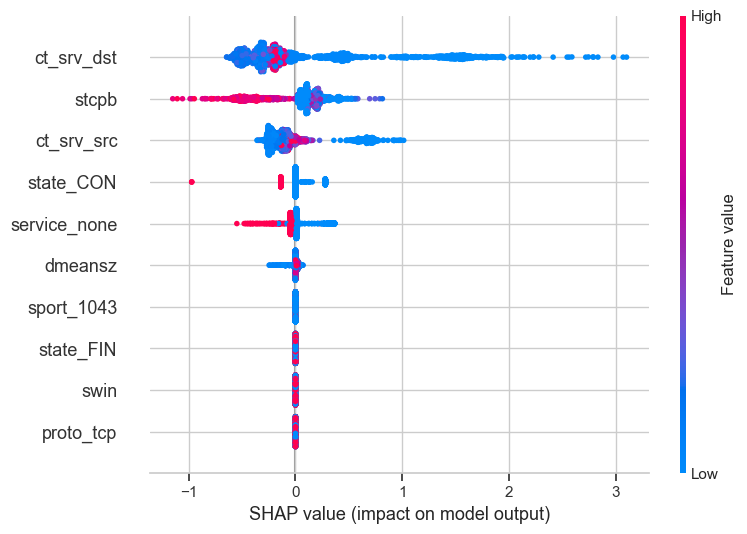

In [41]:
shap.summary_plot(shap_xgb4[:, :][:, cols], X_test.iloc[:, cols])

 Sparse Data

In [42]:
cols2 = [217, 175, 251, 8, 180, 43, 274, 186, 254, 6]
names2 = X_train[X_train.columns[[217, 175, 251, 8, 180, 43, 274, 186, 254, 6]]].columns
print(names)

Index(['state_CON', 'proto_tcp', 'dmeansz', 'swin', 'service_none',
       'state_FIN', 'sport_1043', 'ct_srv_src', 'ct_srv_dst', 'stcpb'],
      dtype='object')


Neural Network

Sampled

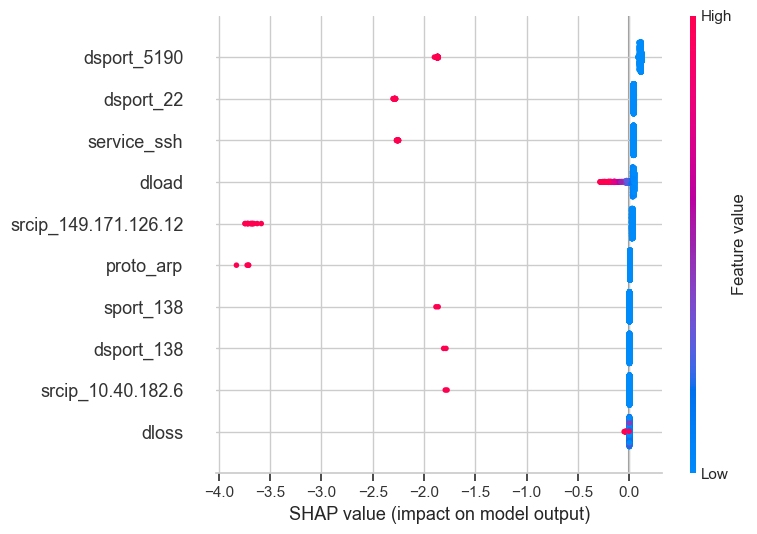

In [43]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap1.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

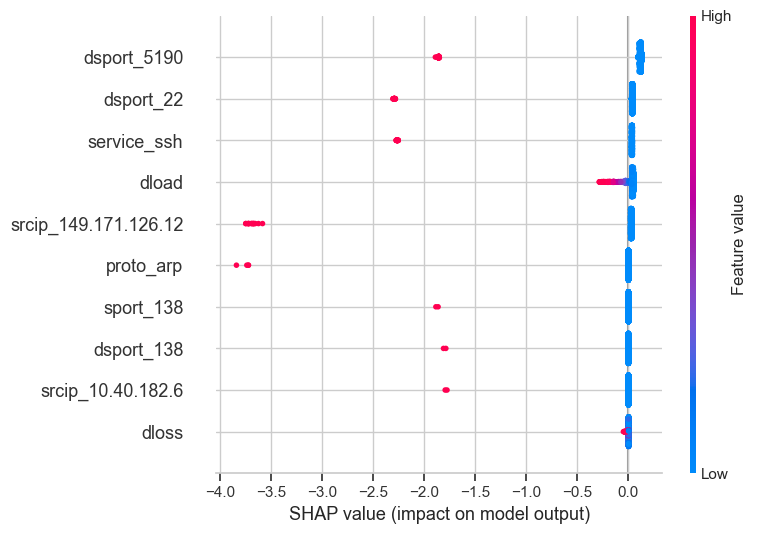

In [44]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap2.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

Standard

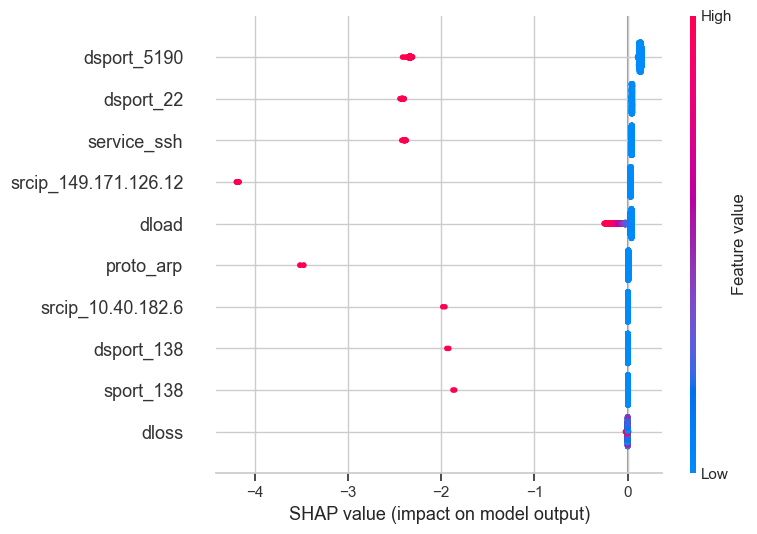

In [45]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap3.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

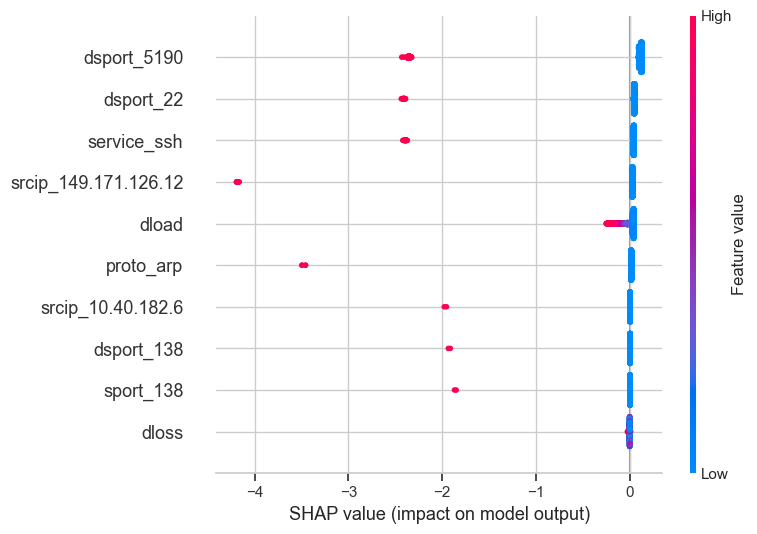

In [46]:
# Sc - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap4.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

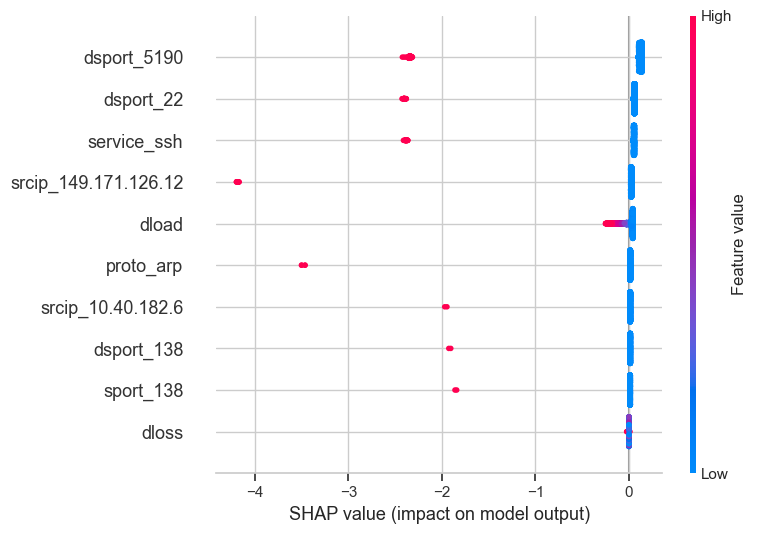

In [47]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap5.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

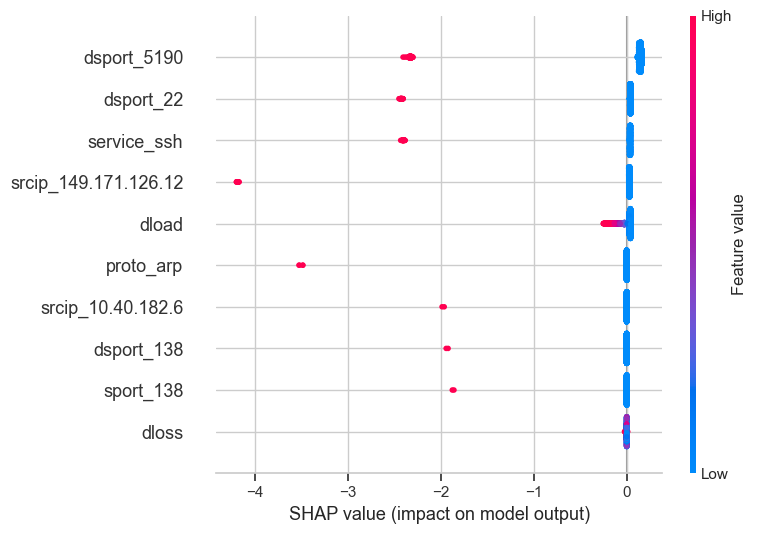

In [48]:
# SC - to enable colour in summary plot, tensor had to be loaded back onto the cpu

shap.summary_plot(shap6.squeeze()[:, cols2], X_test_tensor[:, cols2].detach().cpu().numpy(), feature_names=names2)

Random Forest

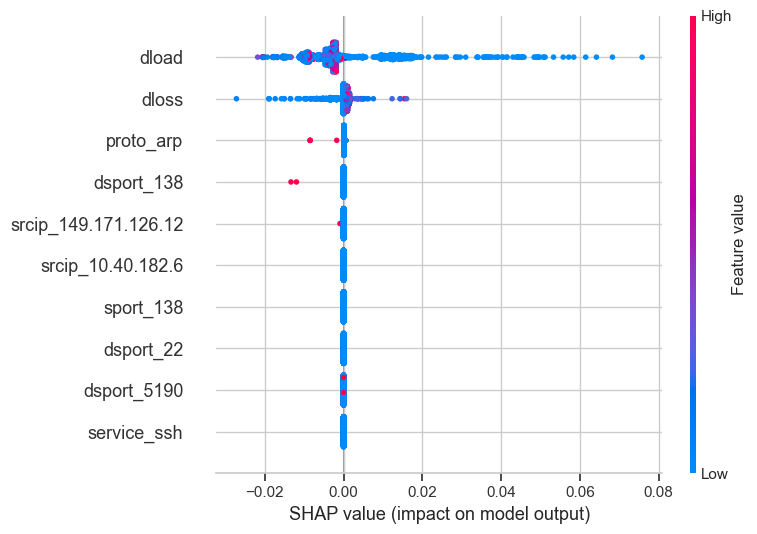

In [49]:
shap.summary_plot(shap_rf1[:, :, 1][:, cols2], X_test.iloc[:, cols2])

XGBoost

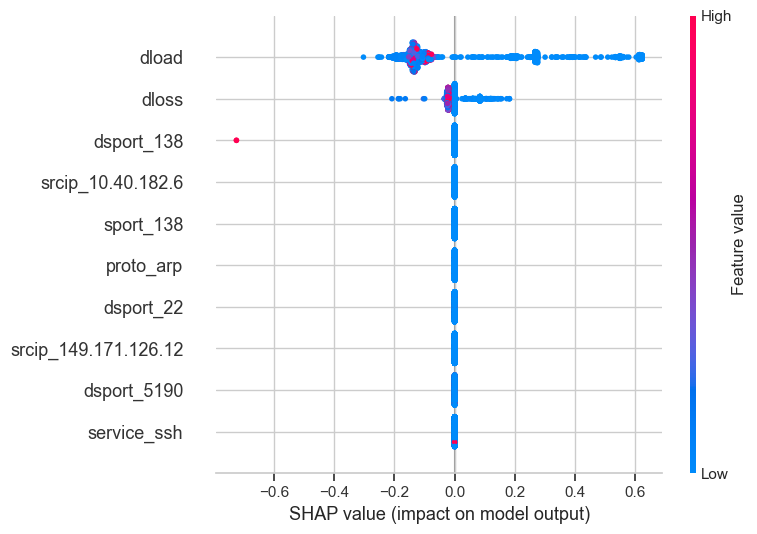

In [50]:
shap.summary_plot(shap_xgb1[:, :][:, cols2], X_test.iloc[:, cols2])

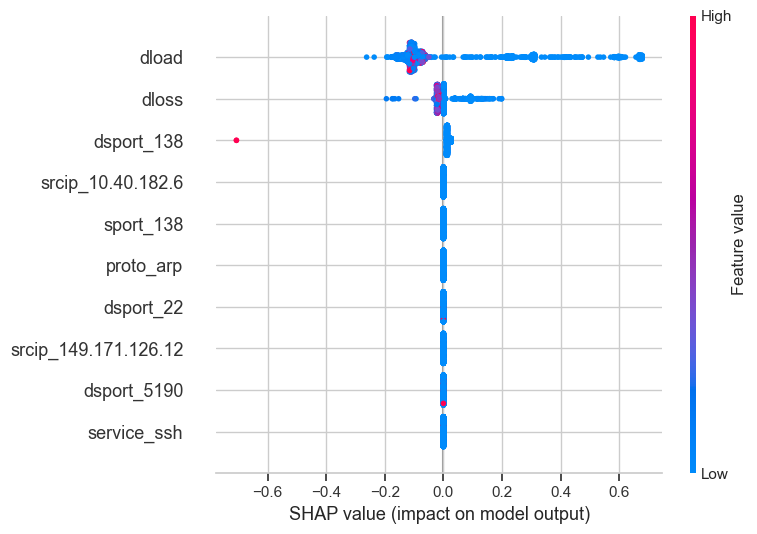

In [51]:
shap.summary_plot(shap_xgb2[:, :][:, cols2], X_test.iloc[:, cols2])

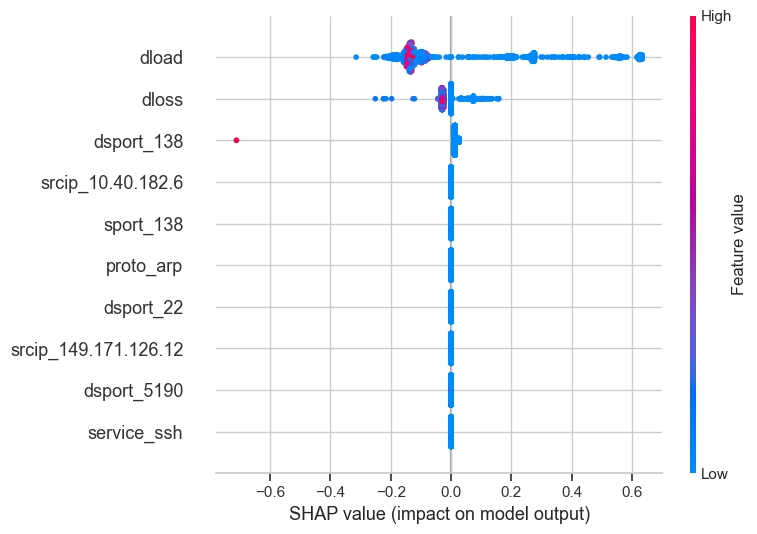

In [52]:
shap.summary_plot(shap_xgb3[:, :][:, cols2], X_test.iloc[:, cols2])

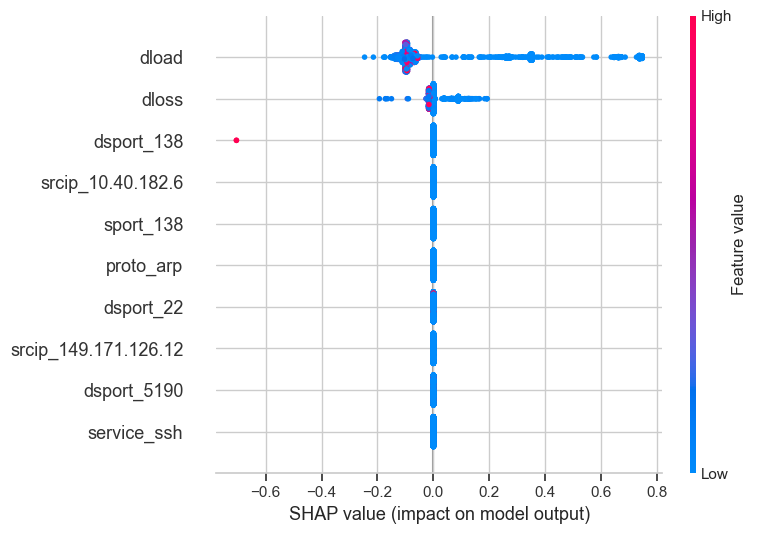

In [53]:
# Corrected to reflect Cols2 - Original run had Cols

shap.summary_plot(shap_xgb4[:, :][:, cols2], X_test.iloc[:, cols2])

Quick Test to compare value counts in the full train and sampled train

In [54]:
# This is no good we might need a bigger sample. - Still the same with bigger sample.
# What does this mean?
# It means that our sampled train data generalises well to the whole train data as background but when using the test set for shap
# we may get extra static representations in shap even though this might not be the case in the trained model.
list = []
for i in X_train.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in train_sample.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))

106
106


Full test and sampled test

In [55]:
list = []
for i in X_test.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in test_sample.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))

165
165


# What about train to test though?

In [56]:
# Ok good we have the difference here so the test is valid when using train background and test shap.
list = []
for i in X_train.columns:
    if X_train[i].nunique() < 2:
        list.append(i)
print(len(list))
list = []
for i in X_test.columns:
    if X_test[i].nunique() < 2:
        list.append(i)
print(len(list))

106
165
